In [61]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque

from tda.nn import TDA, TDAClip

In [151]:
import random
from collections import namedtuple

Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = Experience(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


In [157]:
# Define a custom neural network for the Pendulum environment
class TDANetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_window, scaling_factor):
        super(TDANetwork, self).__init__()
        self.time_window = time_window
        self.fc1 = nn.Linear(input_size * time_window, hidden_size)
        self.tda = TDA(time_window, scaling_factor)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x.T))
        x = x.unsqueeze(-1)
        x = self.tda(x)
        x = x.sum(dim=2)
        x = torch.tanh(self.fc2(x))  # Use tanh activation for the output layer
        return x

# Define the agent
class TDAAgent:
    
    def __init__(self, input_size, hidden_size, output_size, time_window, scaling_factor, learning_rate, buffer_size=10000, gamma=0.99, batch_size=64):
        self.model = TDANetwork(input_size, hidden_size,
                                output_size, time_window, scaling_factor)
        self.target_model = TDANetwork(input_size, hidden_size, output_size, time_window, scaling_factor)
        self.target_model.load_state_dict(self.model.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.time_window = time_window
        self.gamma = gamma
        self.batch_size = batch_size

    def update(self, experiences):
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = [np.concatenate(state_window) for state_window in states]
        next_states = [np.concatenate(state_window) for state_window in next_states]

        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions).view(-1)
        rewards = torch.FloatTensor(rewards).view(-1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).view(-1)

        # Update the model
        target = rewards + self.gamma * self.target_model(next_states) * (1 - dones)
        self.train(states, target)
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def predict(self, state_window):
        state_tensor = torch.FloatTensor(state_window).view(-1)
        action = self.model(state_tensor)
        return action.detach().numpy()

    def train(self, state_window, target):
        state_tensor = torch.FloatTensor(state_window).view(-1)
        target_tensor = torch.FloatTensor(target).unsqueeze(0)
        self.optimizer.zero_grad()
        prediction = self.model(state_tensor)
        loss = torch.mean((prediction - target_tensor) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)  # Add gradient clipping
        self.optimizer.step()

In [158]:
def train_agent(agent, episodes, gamma, epsilon_start, epsilon_end, epsilon_decay, update_target_every):
    env = gym.make('Pendulum-v1')
    epsilon = epsilon_start

    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        state_window = deque([state] * agent.time_window, maxlen=agent.time_window)
        done = False
        episode_reward = 0
        steps = 0
        while not done:
            action = agent.predict(state_window)
            # Exploration
            if np.random.rand() < epsilon:
                action = env.action_space.sample()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            reward = reward if isinstance(reward, np.float64) else sum(reward)
            agent.buffer.push(state, action, reward, next_state, done)

            if len(agent.buffer) >= agent.batch_size:
                experiences = agent.buffer.sample(agent.batch_size)
                agent.update(experiences)

            episode_reward += reward
            state_window.append(next_state)

            # Update the agent
            target = reward + gamma * agent.predict(state_window)
            agent.train(state_window, target)

            state = next_state
            steps += 1
            epsilon = max(epsilon_end, epsilon * epsilon_decay)  # Decay epsilon

        total_rewards.append(episode_reward)
        if (episode + 1) % 100 == 0:
            print(f"Episode: {episode}, Reward: {episode_reward}")

        if episode % update_target_every == 0:
            agent.update_target_network()
    
    return total_rewards

# Set up the agent and training parameters
input_size = 3
hidden_size = 64
output_size = 1
time_window = 10
scaling_factor = 1.0
learning_rate = 0.001
episodes = 1000
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Initialize the agent
agent = TDAAgent(input_size, hidden_size, output_size, time_window, scaling_factor, learning_rate)


In [159]:
# Train the agent
rewards = train_agent(agent, episodes, gamma, epsilon_start, epsilon_end, epsilon_decay, 10)

/Users/andrei/miniforge3/envs/rdl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


ValueError: zero-dimensional arrays cannot be concatenated

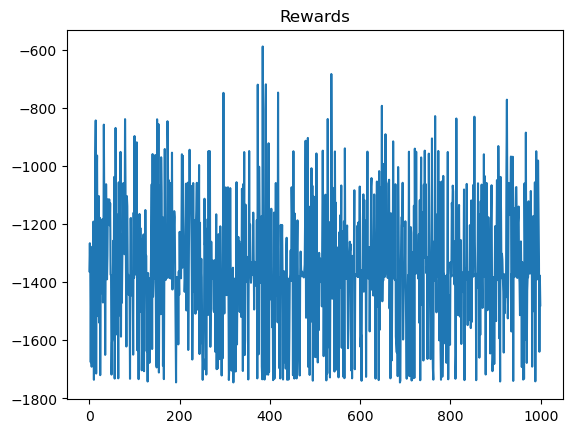

In [149]:
# Plot the rewards
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Rewards")
plt.plot(rewards)
plt.show()

In [140]:
rewards

[array([-1266.7164], dtype=float32),
 array([-1449.1514], dtype=float32),
 array([-1079.915], dtype=float32),
 array([-1566.1954], dtype=float32),
 array([-1383.953], dtype=float32),
 array([-1195.3547], dtype=float32),
 array([-1350.0673], dtype=float32),
 array([-1304.0881], dtype=float32),
 array([-1383.3112], dtype=float32),
 array([-1458.5315], dtype=float32),
 array([-949.8648], dtype=float32),
 array([-1377.4651], dtype=float32),
 array([-1391.4587], dtype=float32),
 array([-1361.6381], dtype=float32),
 array([-1283.8612], dtype=float32),
 array([-1170.7483], dtype=float32),
 array([-1572.3121], dtype=float32),
 array([-1436.8456], dtype=float32),
 array([-1268.324], dtype=float32),
 array([-1633.9093], dtype=float32),
 array([-1189.4419], dtype=float32),
 array([-1379.5791], dtype=float32),
 array([-1561.0482], dtype=float32),
 array([-1145.2428], dtype=float32),
 array([-1694.7274], dtype=float32),
 array([-1475.4373], dtype=float32),
 array([-1359.9235], dtype=float32),
 arra